In [ ]:

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer


# Load dataset
df = pd.read_csv('t_mobil_partner_stc_data.csv')  # adjust if needed

# Use only numeric columns for correlation
numeric_df = df.select_dtypes(include=[np.number])

# Drop features highly correlated with target
corr_with_target = numeric_df.corr()['Churn Value'].drop('Churn Value')
high_corr_feats = corr_with_target[abs(corr_with_target) > 0.9].index.tolist()
print("Dropped due to high correlation:", high_corr_feats)
df = df.drop(columns=high_corr_feats)

# Separate features and target
# Separate features and target
X = df.drop('Churn Value', axis=1)
y = df['Churn Value']

# Drop obviously identifier-like columns (adjust as needed)
for col in X.select_dtypes(include='object').columns:
    if X[col].nunique() > 50:  # threshold: drop high-cardinality categorical columns
        print(f"Dropping high-cardinality column: {col}")
        X.drop(columns=col, inplace=True)

# One-hot encode remaining categorical columns
X = pd.get_dummies(X, drop_first=True)

# Final check: remove any remaining non-numeric columns
X = X.select_dtypes(include=[np.number])

# Drop any rows with missing values
X = X.dropna()
y = y.loc[X.index]  # Align target values


# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale numeric features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Define models with controlled complexity
models = {
    "Logistic Regression": LogisticRegression(max_iter=500),
    "Random Forest": RandomForestClassifier(n_estimators=50, max_depth=5, random_state=42),
    "XGBoost": XGBClassifier(n_estimators=50, max_depth=5, eval_metric='logloss', use_label_encoder=False)
}

# Evaluate each model before optimization
print("\n📊 Performance BEFORE Optimization:\n")
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]
    acc = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_proba)
    print(f"{name} - Accuracy: {acc:.4f}, ROC AUC: {auc:.4f}")

# Voting classifier (soft voting)
voting_clf = VotingClassifier(estimators=[
    ('lr', models["Logistic Regression"]),
    ('rf', models["Random Forest"]),
    ('xgb', models["XGBoost"])
], voting='soft')

voting_clf.fit(X_train, y_train)
y_pred = voting_clf.predict(X_test)
y_proba = voting_clf.predict_proba(X_test)[:, 1]
acc = accuracy_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_proba)
print(f"\n🤝 Voting Classifier - Accuracy: {acc:.4f}, ROC AUC: {auc:.4f}")

Dropped due to high correlation: []
Dropping high-cardinality column: Customer ID
Dropping high-cardinality column: Location ID
Dropping high-cardinality column: Service ID
Dropping high-cardinality column: county
Dropping high-cardinality column: area_codes
Dropping high-cardinality column: arpu_5g
Dropping high-cardinality column: arpu_4g
Dropping high-cardinality column: Status ID

📊 Performance BEFORE Optimization:

Logistic Regression - Accuracy: 0.9470, ROC AUC: 0.8237
Random Forest - Accuracy: 0.9477, ROC AUC: 0.8558


c:\Users\ssamy\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [00:53:21] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost - Accuracy: 0.9519, ROC AUC: 0.8747


c:\Users\ssamy\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [00:53:42] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



🤝 Voting Classifier - Accuracy: 0.9497, ROC AUC: 0.8660


In [ ]:
# Step 2: Load and Preprocess Data
df = pd.read_csv('t_mobil_partner_stc_data.csv')
df.drop(['Customer ID', 'Month', 'zip_code'], axis=1, inplace=True, errors='ignore')

# Encode categorical variables
for col in df.select_dtypes(include='object').columns:
    df[col] = LabelEncoder().fit_transform(df[col].astype(str))

# Impute missing values
df = pd.DataFrame(SimpleImputer(strategy='median').fit_transform(df), columns=df.columns)

# Feature-target split
X = df.drop('Churn Value', axis=1)
y = df['Churn Value']


In [ ]:
# Step 3: Fast Feature Selection using Tree-Based Feature Importances
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel

# 1. Fit a fast ensemble model
model = ExtraTreesClassifier(n_estimators=100, random_state=42, n_jobs=-1)
model.fit(X, y)

# 2. Select top 20 features based on importance
importances = model.feature_importances_
top_indices = importances.argsort()[-20:]  # top 20

# 3. Keep only top 20 features
selected_features = X.columns[top_indices]
X = X[selected_features]

In [ ]:
# Step 4: Scale and Split the Data
X_scaled = StandardScaler().fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)


In [ ]:
# Step 5: Train Optimized Voting Classifier
voting_clf = VotingClassifier(
    estimators=[
        ('rf', RandomForestClassifier(n_estimators=50, random_state=42, n_jobs=-1)),
        ('xgb', XGBClassifier(n_estimators=50, use_label_encoder=False, eval_metric='logloss', n_jobs=-1)),
        ('lr', LogisticRegression(max_iter=500))
    ],
    voting='soft',
    n_jobs=-1
)

voting_clf.fit(X_train, y_train)


VotingClassifier(estimators=[('rf',
                              RandomForestClassifier(n_estimators=50, n_jobs=-1,
                                                     random_state=42)),
                             ('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric='logloss',
                                            feature_types=None,
                                            feature_wei...
                                            interaction_constraints=None,
                                            learning_rate=None, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=None,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=50, n_jobs=-1,
                                            num_parallel_tree=None, ...)),
                             ('lr', LogisticRegression(max_iter=500))],
                 n_jobs=-1, voting='soft')

In [ ]:
# Step 6: Evaluate the Model
y_pred = voting_clf.predict(X_test)
print(classification_report(y_test, y_pred))
print("ROC-AUC Score:", roc_auc_score(y_test, voting_clf.predict_proba(X_test)[:, 1]))


NameError: name 'classification_report' is not defined

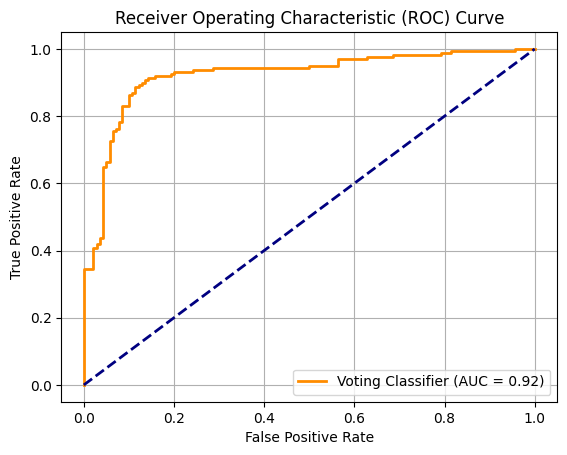

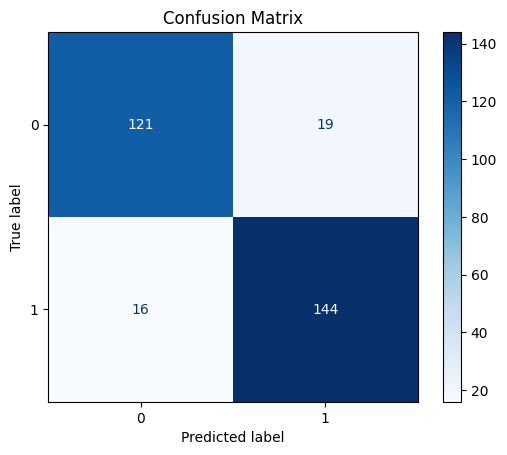

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay

# Step 1: Generate a synthetic classification dataset
X, y = make_classification(
    n_samples=1000,
    n_features=20,
    n_informative=10,
    n_redundant=5,
    n_clusters_per_class=2,
    flip_y=0.1,
    random_state=42
)

# Step 2: Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

# Step 3: Create base models
log_clf = LogisticRegression(max_iter=1000)
rf_clf = RandomForestClassifier(random_state=42)
svc_clf = SVC(probability=True)  # Needed for predict_proba in voting classifier

# Step 4: Create and train Voting Classifier
voting_clf = VotingClassifier(
    estimators=[
        ('lr', log_clf),
        ('rf', rf_clf),
        ('svc', svc_clf)
    ],
    voting='soft'  # Soft voting uses predicted probabilities
)

voting_clf.fit(X_train, y_train)

# Step 5: Make predictions
y_proba = voting_clf.predict_proba(X_test)[:, 1]  # Probabilities for ROC
y_pred = voting_clf.predict(X_test)              # Class predictions for Confusion Matrix

# Step 6: Compute ROC curve and AUC
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

# Step 7: Plot ROC Curve
plt.figure()
plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"Voting Classifier (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# Step 8: Plot Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=voting_clf.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()
